In [99]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1008]:
import pandas as pd
import itertools
from collections import namedtuple
from plotnine import *
from multiprocessing import Pool
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [1009]:
n_splits = 8
animals = pd.read_csv('animals2.csv')
animals = animals.rename(columns = {'Unnamed: 0':'ID'})
animals.drop(['MostPopNames', 'AgeInDaysCategorical', 'Time', 'Date'], inplace=True, axis=1)

In [1010]:
animals.Hair = pd.Categorical(animals.Hair, categories=['Short', 'Medium', 'Long', 'Unknown']).codes # NaN becomes -1
animals.loc[animals.Hair == -1, 'Hair'] = np.nan
animals.Stage = pd.Categorical(animals.Stage, categories=[
    'NewBorn', '1MoSpike', '2MoSpike', 'KittenPuppy', 'Adult', 'OldAge']).codes
animals.HasName = pd.Categorical(animals.HasName, categories=['Named', 'Unnamed']).codes

df = animals[all((animals["SexuponOutcome"] != "Unknown", 
             animals["AnimalType"]=="Cat", 
             animals["AgeInDays"] < 30), 
            axis=0)]
from scipy.stats import bernoulli
vc = df["SexuponOutcome"].value_counts()
im_prob = vc["Intact Male"] / float(744+642+1)
blah = bernoulli.rvs(im_prob, size=10000)
def unknown_sex(sexstring):
    if sexstring == "Unknown":
        sex = bernoulli.rvs(im_prob, random_state=127)
        if sex == 1:
            return "Intact Male"
        else:
            return "Intact Female"
    else:
        return sexstring

animals["TransformedSex"] = pd.Categorical(
    animals["SexuponOutcome"].apply(unknown_sex),
    categories=['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female']).codes
animals['type'] = pd.Categorical(animals.AnimalType, categories=['Cat', 'Dog']).codes
cols = [0, 7] + range(11,42) # was 11, 39 on Xian's dataset (and missing 6 and 7)
cats = animals[animals.AnimalType=='Cat'].iloc[:,cols]
dogs = animals[animals.AnimalType=='Dog'].iloc[:,cols]

Fix the NaN values for cats and dogs seperately because we have some different columns for each and don't want to impute values using the median from the other animal type.

In [1011]:
# pd.isnull(cats).sum() > 0

In [1012]:
imputer = Imputer(strategy='median')   

# for cats set values taht make sense for these (i.e. 1-5 scale: choose 3)
cats.iloc[:, 12:28] = 5  # was 10:26 on Xian's
cats['Avg Weight (pounds)'] = 9
cats['Avg Height (inches)'] = 9
cats['Avg Age'] = 12
dogs.Hair = 2

In [1013]:
# [(i, x) for i, x in enumerate(pd.merge(dogs, pd.DataFrame(imputer.fit_transform(dogs), columns = animals.iloc[:, cols].columns), 
#                 how='inner', on='ID'))]

In [1014]:
dogs.fillna(dogs.median(), axis=0, inplace=True)
cats.fillna(cats.median(), axis=0, inplace=True)

outcomes = pd.DataFrame(animals.iloc[:, [0, 4]])
animals = pd.concat([dogs, cats])
animals = pd.merge(animals, outcomes, on='ID')
animals.columns = [x.replace('_y', '') for x in animals.columns]

[(i, x) for i, x in enumerate(animals.columns)]
# pd.isnull(animals).sum() > 0

[(0, 'ID'),
 (1, 'SexuponOutcome'),
 (2, 'Sex'),
 (3, 'Genitals'),
 (4, 'AgeInDays'),
 (5, 'HasName'),
 (6, 'Stage'),
 (7, 'Hour'),
 (8, 'WeekDay'),
 (9, 'Month'),
 (10, 'WeekOfYear'),
 (11, 'IsHoliday'),
 (12, 'Protects Property'),
 (13, 'Hunts & Chases'),
 (14, 'Less Likely to Wander'),
 (15, 'Loving'),
 (16, 'Child-Friendly'),
 (17, 'Dog-Friendly'),
 (18, 'Pet-Friendly'),
 (19, 'Stranger-Friendly'),
 (20, 'Avg Height (inches)'),
 (21, 'Avg Weight (pounds)'),
 (22, 'Size Score (1 to 5)'),
 (23, 'Avg Age'),
 (24, 'Fewer Health Issues'),
 (25, 'Energetic'),
 (26, 'Intelligent'),
 (27, 'Easy to Train'),
 (28, 'IsMix'),
 (29, 'Hair'),
 (30, 'IsMultiColor'),
 (31, 'TransformedSex'),
 (32, 'type'),
 (33, 'OutcomeType')]

In [1015]:
animals.drop(['Sex', 'Genitals', 'SexuponOutcome'], inplace=True, axis=1)

In [1016]:
# Helpful if adding to Xian's dataset, already in mine

# def stage(x):
#     if x <= 28:
#         return 'NewBorn'
#     elif x > 28 and x <= 35:
#         return '1MoSpike'
#     elif x > 35 and x <= 60:
#         return '2MoSpike'
#     elif x > 60 and x < 365:
#         return 'KittenPuppy'
#     elif x >= 365 and x < 10 * 365:
#         return 'Adult'
#     elif x >= 10 * 356:
#         return 'OldAge'    

# outcome_type = animals.pop('OutcomeType')

# animals['Stage'] = animals.AgeinDays.map(stage)
# animals.Stage = pd.Categorical(animals.Stage, categories=[
#     'NewBorn', '1MoSpike', '2MoSpike', 'KittenPuppy', 'Adult', 'OldAge']).codes

# animals['OutcomeType'] = outcome_type


In [1017]:
outcome_type = animals.pop('OutcomeType')
for c in animals.columns:
    if c in ['AgeInDays',
             'HasName',
             'Stage',
             'Hour',
             'WeekDay',
             'Month',
             'WeekOfYear',
             'IsHoliday',
             'Protects Property',
             'Hunts & Chases',
             'Less Likely to Wander',
             'Loving',
             'Child-Friendly',
             'Dog-Friendly',
             'Pet-Friendly',
             'Stranger-Friendly',
             #'Avg Height (inches)',
             #'Avg Weight (pounds)',
             'Size Score (1 to 5)',
             #'Avg Age',
             'Fewer Health Issues',
             'Energetic',
             'Intelligent',
             'Easy to Train',
             'IsMix',
             'Hair',
             'IsMultiColor',
             'TransformedSex',
             'type']:
        animals = pd.concat([animals, pd.get_dummies(pd.Categorical(animals[c]), prefix=c)], axis=1)
animals['OutcomeType'] = outcome_type
[(i, x) for i, x in enumerate(animals.columns)]


[(0, 'ID'),
 (1, 'AgeInDays'),
 (2, 'HasName'),
 (3, 'Stage'),
 (4, 'Hour'),
 (5, 'WeekDay'),
 (6, 'Month'),
 (7, 'WeekOfYear'),
 (8, 'IsHoliday'),
 (9, 'Protects Property'),
 (10, 'Hunts & Chases'),
 (11, 'Less Likely to Wander'),
 (12, 'Loving'),
 (13, 'Child-Friendly'),
 (14, 'Dog-Friendly'),
 (15, 'Pet-Friendly'),
 (16, 'Stranger-Friendly'),
 (17, 'Avg Height (inches)'),
 (18, 'Avg Weight (pounds)'),
 (19, 'Size Score (1 to 5)'),
 (20, 'Avg Age'),
 (21, 'Fewer Health Issues'),
 (22, 'Energetic'),
 (23, 'Intelligent'),
 (24, 'Easy to Train'),
 (25, 'IsMix'),
 (26, 'Hair'),
 (27, 'IsMultiColor'),
 (28, 'TransformedSex'),
 (29, 'type'),
 (30, 'AgeInDays_0.0'),
 (31, 'AgeInDays_1.0'),
 (32, 'AgeInDays_2.0'),
 (33, 'AgeInDays_3.0'),
 (34, 'AgeInDays_4.0'),
 (35, 'AgeInDays_5.0'),
 (36, 'AgeInDays_6.0'),
 (37, 'AgeInDays_7.0'),
 (38, 'AgeInDays_14.0'),
 (39, 'AgeInDays_21.0'),
 (40, 'AgeInDays_28.0'),
 (41, 'AgeInDays_30.0'),
 (42, 'AgeInDays_35.0'),
 (43, 'AgeInDays_60.0'),
 (44, 'AgeIn

In [1018]:
def skf_generator(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    for train_index, test_index in skf.split(np.zeros(len(t)), t):
        yield train_index, test_index

def run_skf(data, n_splits):
    splits = [(data.iloc[train_index], data.iloc[test_index]) 
              for train_index, test_index in skf_generator(data, n_splits=n_splits)]
    return zip(*splits) # return seperate lists of train/test instead of one combined

In [1019]:
def visualize_folds(data, train, test):
    print('Number of training samples: {}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

In [1020]:
columns = ['ID',
 'AgeInDays',
 'HasName',
 'Stage',
 'Hour',
 'WeekDay',
 'Month',
 'WeekOfYear',
 'IsHoliday',
 'Protects Property',
 'Hunts & Chases',
 'Less Likely to Wander',
 'Loving',
 'Child-Friendly',
 'Dog-Friendly',
 'Pet-Friendly',
 'Stranger-Friendly',
 'Avg Height (inches)',
 'Avg Weight (pounds)',
 'Size Score (1 to 5)',
 'Avg Age',
 'Fewer Health Issues',
 'Energetic',
 'Intelligent',
 'Easy to Train',
 'IsMix',
 'Hair',
 'IsMultiColor',
 'TransformedSex',
 'type',
 'OutcomeType']

data, validate = train_test_split(animals, test_size=1./(n_splits+1), random_state=8)
print 'Number of samples before splitting: {}'.format(len(animals))
print 'Number of validation samples: {}'.format(len(validate))
train, test = run_skf(data, n_splits)
visualize_folds(data, train, test)

Number of samples before splitting: 26729
Number of validation samples: 2970
Number of training samples: 23759

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,8356,152,1204,3745,7330,20787
Fold 2,8356,152,1205,3745,7330,20788
Fold 3,8356,152,1205,3745,7331,20789
Fold 4,8356,152,1205,3745,7331,20789
Fold 5,8356,152,1205,3745,7331,20789
Fold 6,8356,152,1205,3745,7331,20789
Fold 7,8357,153,1205,3745,7331,20791
Fold 8,8357,153,1205,3745,7331,20791


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1194,22,173,535,1048,2972
Fold 2,1194,22,172,535,1048,2971
Fold 3,1194,22,172,535,1047,2970
Fold 4,1194,22,172,535,1047,2970
Fold 5,1194,22,172,535,1047,2970
Fold 6,1194,22,172,535,1047,2970
Fold 7,1193,21,172,535,1047,2968
Fold 8,1193,21,172,535,1047,2968


In [1021]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

In [1022]:
def plot_results(X, t, target_names, loss, pred, n_splits, show_title=True):
    print('')
    if show_title:
        print('Fold {} of {}'.format(len(loss.train), n_splits))
        print('Train log loss: {}'.format(loss.train[-1]))
    print('Test log loss: {}'.format(loss.test[-1]))
    
    if show_title:
        title = 'Confusion Matrix for Fold {0} of {1}'.format(len(loss), n_splits)
    else:
        title = ""
    cm = confusion_matrix(t.test, pred.test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title=title)
    print(classification_report(t.test, pred.test, target_names=target_names))

In [1023]:
def plot_importance(clf, X, t):
    print('Classifier score (accuracy): {}'.format(clf.score(X.test, t.test)))

    if not hasattr(clf, 'feature_importances_'):
        return
    # Print the feature ranking
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.train.shape[1]), X.train.columns[indices], rotation=90)
    plt.xlim([-1, X.train.shape[1]])
    plt.show()

In [1024]:
def create_output(t_true, t_pred, target_names):
    k1 = pd.get_dummies(t_pred, columns=target_names)
    k1 = k1.reindex_axis(target_names, axis=1)
    k1.fillna(0, inplace=True)
    return k1

In [1025]:
def calc_ln_loss(t_true, t_pred, target_names):
    return log_loss(t_true, t_pred)
    #return log_loss(pd.get_dummies(t_true, columns=target_names), 
    #                create_output(t_true, t_pred, target_names))

In [1026]:
def ln_loss_scorer(clf, X, t):
    # pred = clf.predict(X)
    # Hack Notice: target_names not passed in, so it's global...
    # return calc_ln_loss(t, pred, target_names)
    pred = clf.predict_proba(X)
    log_loss(t, pred)

In [1027]:
from sklearn.preprocessing  import LabelEncoder

le = LabelEncoder()


def run_classifier(clf, X, t, target_names, loss):    
    clf.fit(X.train, t.train)
    pred = TrainTest(pd.Categorical(clf.predict(X.train), categories=target_names),
                     pd.Categorical(clf.predict(X.test), categories=target_names))

    pred_proba = TrainTest(clf.predict_proba(X.train), clf.predict_proba(X.test))
    
    loss.train.append(calc_ln_loss(t.train, pred_proba.train, target_names))
    loss.test.append(calc_ln_loss(t.test, pred_proba.test, target_names))
    
    
    return clf, pred, loss

In [1028]:
TrainTest = namedtuple('TrainTest', 'train, test')
target_names = sort(animals.OutcomeType.unique())

In [1029]:
def run_classifier_CV(clf, train, test, target_names, loss, plot=False):
    clfs = []
    for i in range(len(train)):
        this_clf = clone(clf)
        # ID is in first column, outcome is in Last
        X = TrainTest(train[i].iloc[:, 1:-1], test[i].iloc[:, 1:-1])
        t = TrainTest(pd.Categorical(train[i].OutcomeType, categories=target_names),
                      pd.Categorical(test[i].OutcomeType, categories=target_names))
        this_clf, pred, loss = run_classifier(this_clf, X, t, target_names, loss)
        if plot:
            plot_results(X, t, target_names, loss, pred, len(train))
            plot_importance(this_clf, X, t)
        clfs.append(this_clf)
    return clfs


In [1030]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15,
                             random_state=8, max_features='auto', n_jobs= -1)
df = data.iloc[:, range(1, 251)]
rf_clf.fit(df, data.iloc[:,-1])
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf_clf, threshold="1.5*median", prefit=True)
columns = df.columns[model.get_support(indices=True).tolist()].tolist()

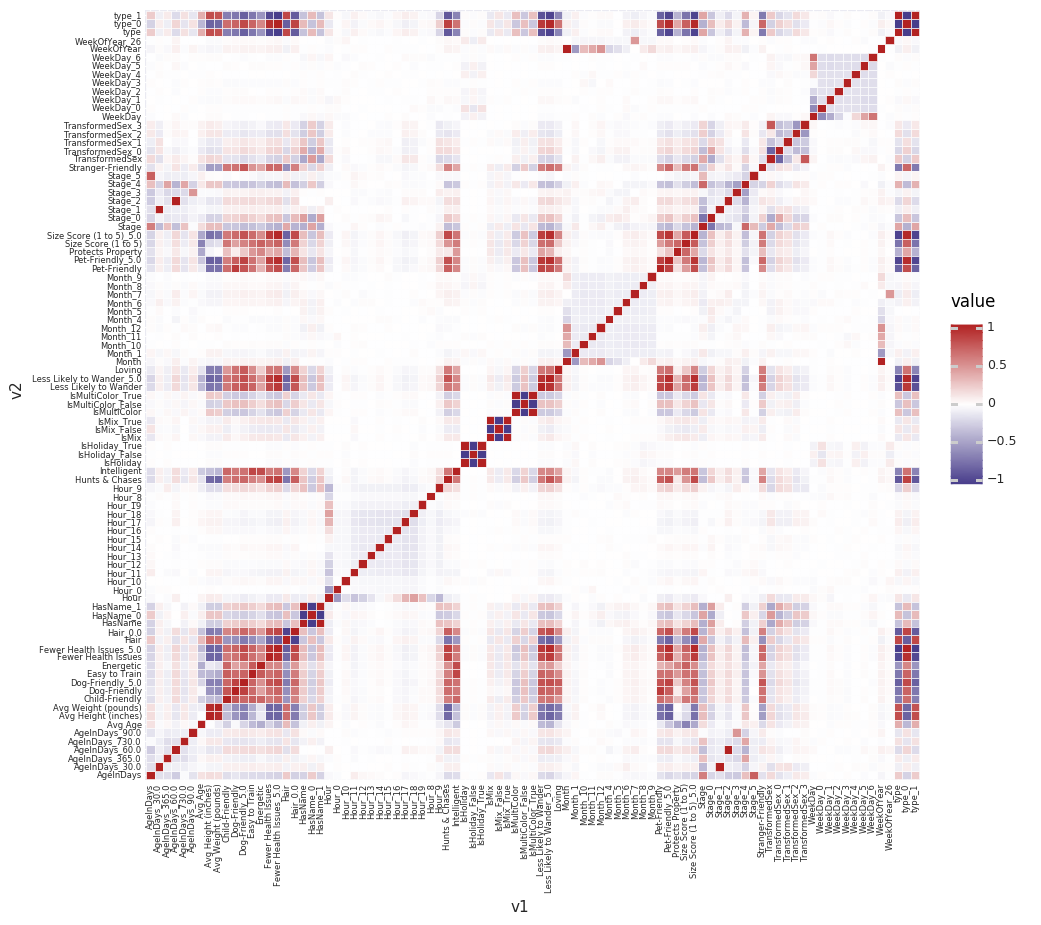

In [1031]:
df_corr = animals.loc[:,  columns].corr()

# ICD.display(df_corr)

df_corr = df_corr.stack().reset_index()
df_corr.columns = ['v1','v2','value']

(ggplot(df_corr, aes(x='v1', y='v2', fill='value'))
 + geom_tile(color='white', size=0.25)
 + scale_fill_gradientn(colors=('darkslateblue', 'white', 'firebrick'))
 + theme_seaborn()
 + theme(axis_text_x = element_text(angle = 90, size=6),
         axis_text_y = element_text(size=6))
 + coord_equal()
).draw().set_size_inches(10,10)


Fold 1 of 8
Train log loss: 0.504499997626
Test log loss: 0.758662948321
                 precision    recall  f1-score   support

       Adoption       0.71      0.85      0.77      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.74      0.21      0.33       173
Return_to_owner       0.53      0.48      0.50       535
       Transfer       0.78      0.74      0.76      1048

    avg / total       0.70      0.70      0.69      2972

Classifier score (accuracy): 0.701211305518


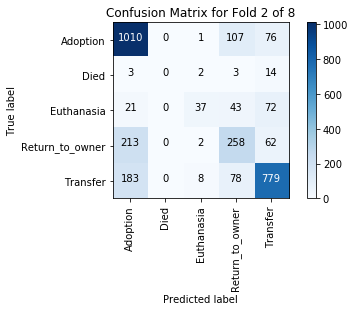

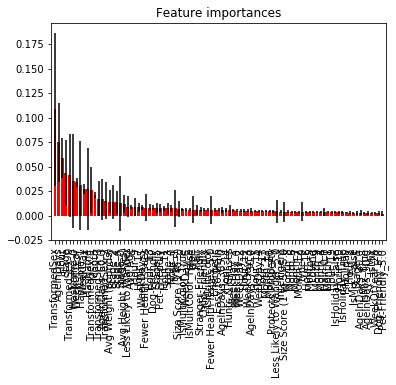


Fold 2 of 8
Train log loss: 0.505422704604
Test log loss: 0.747525225229
                 precision    recall  f1-score   support

       Adoption       0.70      0.86      0.77      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.74      0.23      0.35       172
Return_to_owner       0.52      0.47      0.49       535
       Transfer       0.78      0.71      0.74      1048

    avg / total       0.69      0.69      0.68      2971

Classifier score (accuracy): 0.694042409963


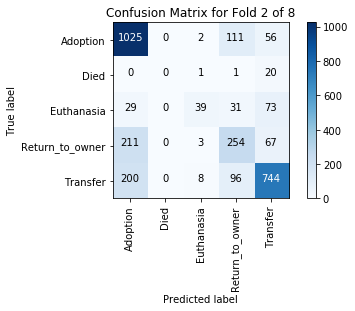

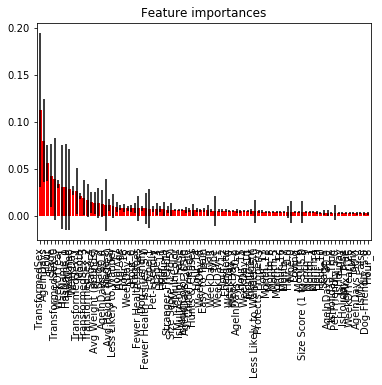


Fold 3 of 8
Train log loss: 0.508146780949
Test log loss: 0.746305029182
                 precision    recall  f1-score   support

       Adoption       0.71      0.86      0.78      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.62      0.16      0.26       172
Return_to_owner       0.54      0.52      0.53       535
       Transfer       0.77      0.72      0.75      1047

    avg / total       0.70      0.70      0.69      2970

Classifier score (accuracy): 0.702356902357


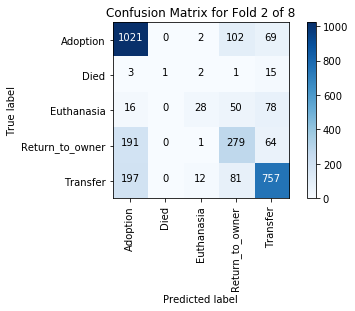

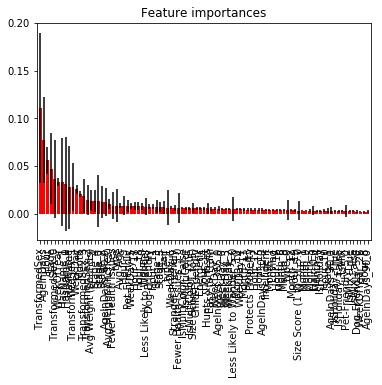


Fold 4 of 8
Train log loss: 0.505772598428
Test log loss: 0.746582528226
                 precision    recall  f1-score   support

       Adoption       0.70      0.86      0.77      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.56      0.16      0.25       172
Return_to_owner       0.53      0.47      0.50       535
       Transfer       0.77      0.73      0.75      1047

    avg / total       0.69      0.70      0.68      2970

Classifier score (accuracy): 0.696296296296


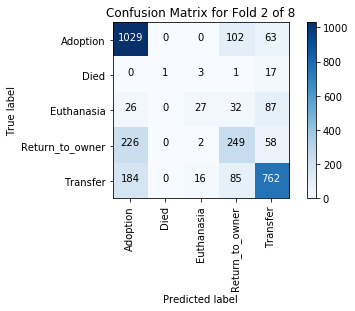

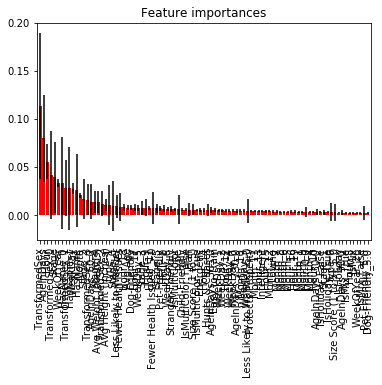


Fold 5 of 8
Train log loss: 0.500765721837
Test log loss: 0.788084309174
                 precision    recall  f1-score   support

       Adoption       0.69      0.83      0.75      1194
           Died       0.67      0.09      0.16        22
     Euthanasia       0.54      0.12      0.20       172
Return_to_owner       0.47      0.46      0.47       535
       Transfer       0.77      0.72      0.74      1047

    avg / total       0.67      0.68      0.66      2970

Classifier score (accuracy): 0.677777777778


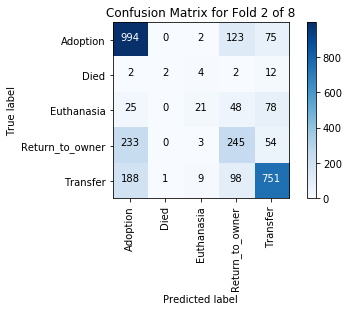

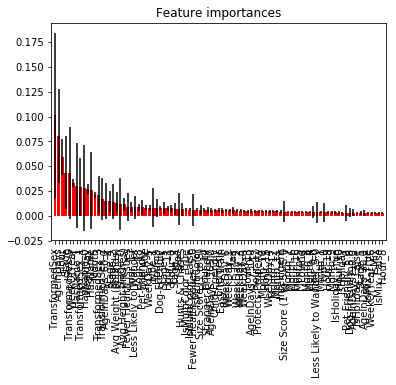


Fold 6 of 8
Train log loss: 0.501721422628
Test log loss: 0.755869781391
                 precision    recall  f1-score   support

       Adoption       0.70      0.85      0.77      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.74      0.22      0.33       172
Return_to_owner       0.53      0.50      0.52       535
       Transfer       0.80      0.73      0.76      1047

    avg / total       0.71      0.70      0.69      2970

Classifier score (accuracy): 0.702356902357


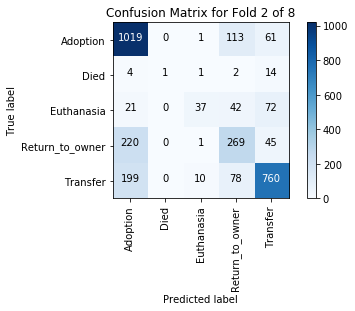

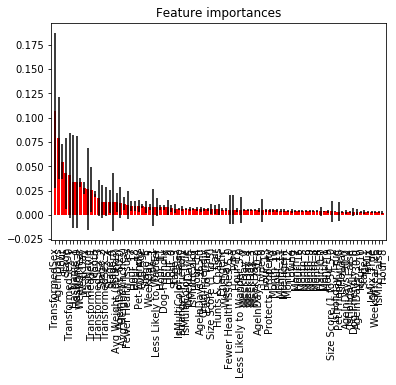


Fold 7 of 8
Train log loss: 0.503346965185
Test log loss: 0.761097784563
                 precision    recall  f1-score   support

       Adoption       0.70      0.86      0.77      1193
           Died       0.00      0.00      0.00        21
     Euthanasia       0.66      0.18      0.28       172
Return_to_owner       0.52      0.50      0.51       535
       Transfer       0.78      0.70      0.74      1047

    avg / total       0.69      0.69      0.68      2968

Classifier score (accuracy): 0.692722371968


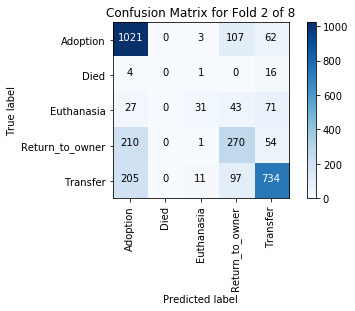

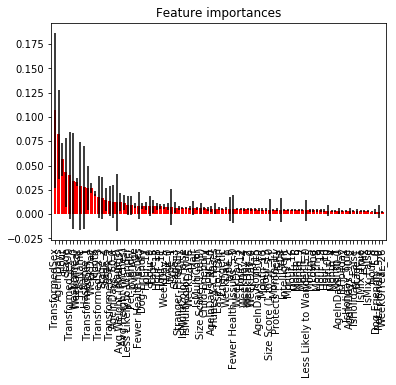


Fold 8 of 8
Train log loss: 0.502399693625
Test log loss: 0.753260434969
                 precision    recall  f1-score   support

       Adoption       0.70      0.84      0.76      1193
           Died       0.67      0.10      0.17        21
     Euthanasia       0.74      0.18      0.29       172
Return_to_owner       0.51      0.50      0.51       535
       Transfer       0.77      0.71      0.74      1047

    avg / total       0.69      0.69      0.68      2968

Classifier score (accuracy): 0.689690026954


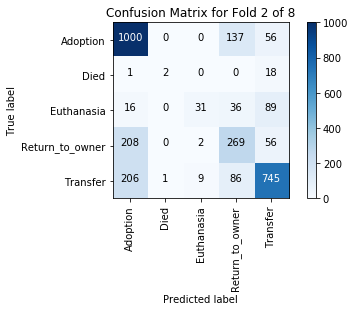

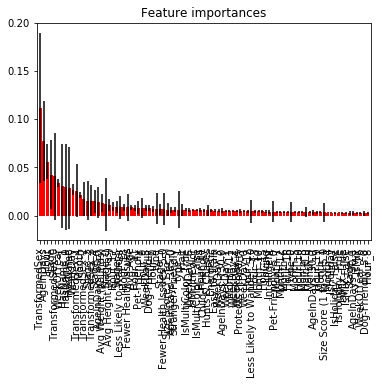

Avg. train log loss: 0.50400948561 std: 0.0022707699318
Avg. test log loss: 0.757173505132 std: 0.0128135177483


In [1032]:
loss = TrainTest([], [])

# columns = train[0].columns[1:30].tolist()
clfs = run_classifier_CV(rf_clf, [x.loc[:, ['ID'] + columns + ['OutcomeType']] for x in train], 
                         [x.loc[:, ['ID'] + columns + ['OutcomeType']] for x in test], target_names, loss, plot=True)
print('Avg. train log loss: {} std: {}'.format(mean(loss.train), std(loss.train)))
print('Avg. test log loss: {} std: {}'.format(mean(loss.test), std(loss.test)))
    


Test log loss: 0.793766320401
                 precision    recall  f1-score   support

       Adoption       0.69      0.83      0.76      1219
           Died       1.00      0.04      0.08        23
     Euthanasia       0.63      0.12      0.21       178
Return_to_owner       0.48      0.49      0.48       506
       Transfer       0.76      0.69      0.72      1044

    avg / total       0.68      0.68      0.66      2970

Without Soft Voting on Folds:

Test log loss: 0.795305214607
                 precision    recall  f1-score   support

       Adoption       0.69      0.83      0.76      1219
           Died       1.00      0.04      0.08        23
     Euthanasia       0.63      0.12      0.21       178
Return_to_owner       0.48      0.49      0.48       506
       Transfer       0.76      0.69      0.72      1044

    avg / total       0.68      0.68      0.66      2970



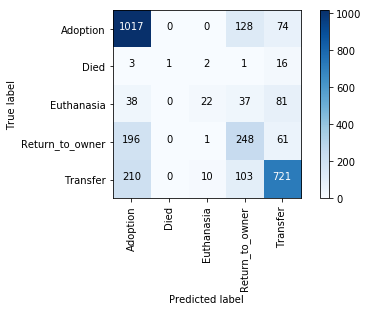

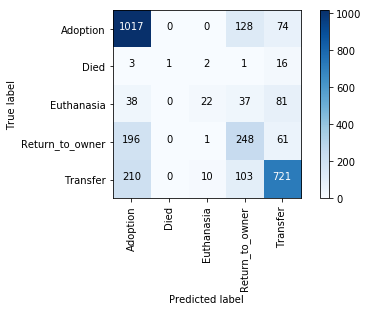

In [1040]:
X = TrainTest(data.loc[:, columns], validate.loc[:, columns])
t = TrainTest(data.OutcomeType, validate.OutcomeType)
pred_proba = average([clfs[i].predict_proba(X.test) for i in range(n_splits)], axis=0)
pred = TrainTest(None, [target_names[argmax(preds[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba, target_names)])

plot_results(X, t, target_names, loss, pred, 1, show_title=False)


print("Without Soft Voting on Folds:")
rf_clf.fit(X.train, t.train)
pred_proba = TrainTest(None, rf_clf.predict_proba(X.test))
pred = TrainTest(None, [target_names[argmax(preds[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba.test, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)



Fold 1 of 8
Train log loss: 0.778110603865
Test log loss: 0.808086529849
                 precision    recall  f1-score   support

       Adoption       0.69      0.84      0.76      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.64      0.13      0.22       173
Return_to_owner       0.51      0.44      0.47       535
       Transfer       0.74      0.71      0.73      1048

    avg / total       0.67      0.68      0.66      2972

Classifier score (accuracy): 0.6766487214

Fold 2 of 8
Train log loss: 0.778038634144
Test log loss: 0.804274742018
                 precision    recall  f1-score   support

       Adoption       0.68      0.85      0.76      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.62      0.17      0.27       172
Return_to_owner       0.51      0.43      0.47       535
       Transfer       0.75      0.70      0.72      1048

    avg / total       0.67      0.68      0.66      2971

Classi

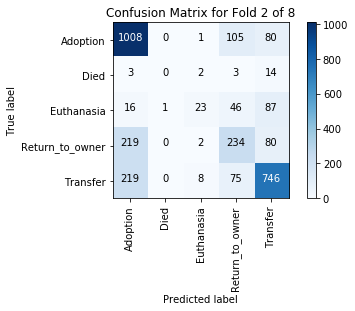

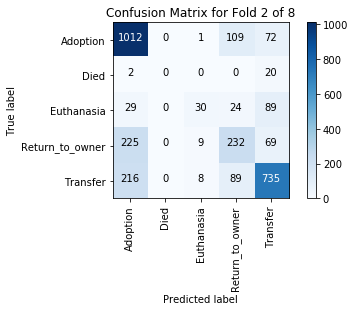

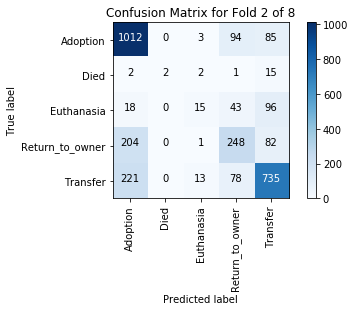

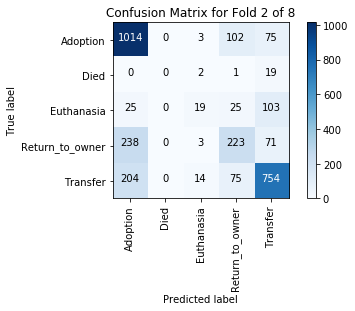

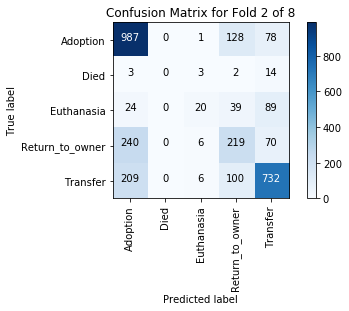

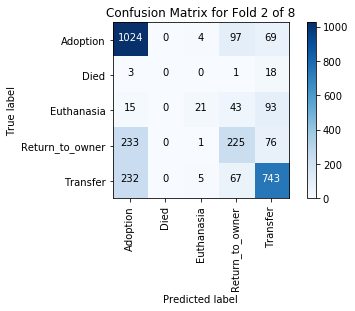

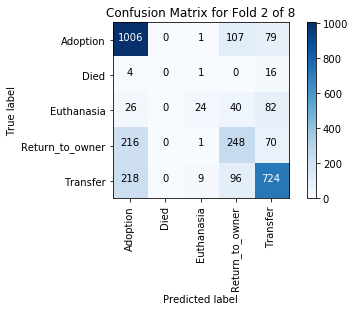

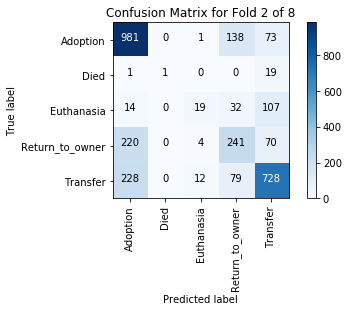

In [1003]:
lr_clf = LogisticRegression(C=1.5, penalty='l2', random_state=8)



loss = TrainTest([], [])
clfs = run_classifier_CV(lr_clf, train, test, target_names, loss, plot=True)
print('Avg. train log loss: {} std: {}'.format(mean(loss.train), std(loss.train)))
print('Avg. test log loss: {} std: {}'.format(mean(loss.test), std(loss.test)))

In [408]:
voting_clf = VotingClassifier([('rf', rf_clf), ('lr', lr_clf)], voting='soft')

# score using cross validation
clf_list = [rf_clf, lr_clf, voting_clf]
name_list = ['Random Forest', 'Logistic Regression', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = cross_val_score(clf, X.train, t.train, scoring=ln_loss_scorer, cv=skf_generator(data, n_splits))
    print("Log Loss: %0.2f +/- %0.2f (%s 95%% CI)" % (scores.mean(), scores.std()*1.96, name))

Log Loss: 10.72 +/- 0.43 (Random Forest 95% CI)
Log Loss: 12.56 +/- 0.52 (Logistic Regression 95% CI)
Log Loss: 10.89 +/- 0.47 (Ensemble 95% CI)


In [829]:
def plot_hypervariable(result, loss, variable):
    columns = ['count', 'train', 'test']
    loss = pd.DataFrame(result, columns=columns)
    loss = pd.melt(loss, id_vars=['count'], value_vars=columns[1:])

    (ggplot(loss, aes(x='count', y='value', color='variable'))
     + geom_line(size=1)
     + theme_seaborn()
     + theme(panel_grid_minor = element_line(size=0.5))
     + ylab('Log Loss')
     + xlab(variable)
    ).draw().set_size_inches(4, 4)

In [28]:
# Takes a while. Only run if needed, and use as many processes as needed

# def iteration(i):
#     try:
#         clf = RandomForestClassifier(n_estimators=100, max_depth=i, 
#                                      random_state=8, max_features='auto')
#         loss = TrainTest([], [])
#         run_classifier_CV(clf, train, test, target_names, loss)
#         return (i, sum(loss.train) / n_splits, sum(loss.test) / n_splits)
#     except:
#         import traceback
#         traceback.print_exc()

# range_ = range(2, 30)
# p = Pool(processes=8)
# result = p.map(iteration, range_)
# p.close()
# p.join()

# plot_hypervariable(result, loss, 'Max Depth')

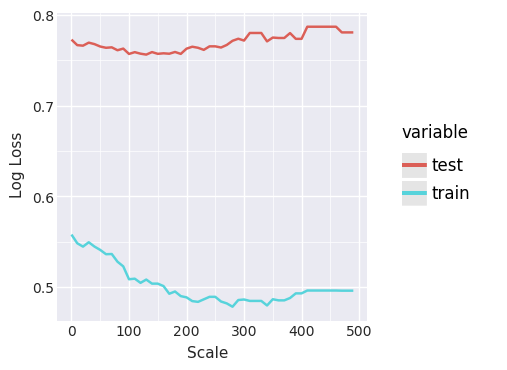

In [999]:

# Takes a while. Only run if needed, and use as many processes as needed

def iteration(i):
    try:
        rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15,
                                     random_state=8, max_features='auto', n_jobs= -1)
        df = data.iloc[:, range(1, 251)]
        rf_clf.fit(df, data.iloc[:,-1])
        threshold = '{0}*median'.format(i/100.)
        from sklearn.feature_selection import SelectFromModel
        model = SelectFromModel(rf_clf, threshold=threshold, prefit=True)
        columns = df.columns[model.get_support(indices=True).tolist()].tolist()

        loss = TrainTest([], [])
        clfs = run_classifier_CV(rf_clf, [x.loc[:, ['ID'] + columns + ['OutcomeType']] for x in train], 
                         [x.loc[:, ['ID'] + columns + ['OutcomeType']] for x in test], target_names, loss)
        return (i, sum(loss.train) / n_splits, sum(loss.test) / n_splits)
    except:
        import traceback
        traceback.print_exc()

range_ = range(0, 500, 10)
p = Pool(processes=8)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, loss, 'Scale')

In [828]:
[(i, x) for i, x in enumerate(animals.columns)]

[(0, 'ID'),
 (1, 'AgeInDays'),
 (2, 'HasName'),
 (3, 'Stage'),
 (4, 'Hour'),
 (5, 'WeekDay'),
 (6, 'Month'),
 (7, 'WeekOfYear'),
 (8, 'IsHoliday'),
 (9, 'Protects Property'),
 (10, 'Hunts & Chases'),
 (11, 'Less Likely to Wander'),
 (12, 'Loving'),
 (13, 'Child-Friendly'),
 (14, 'Dog-Friendly'),
 (15, 'Pet-Friendly'),
 (16, 'Stranger-Friendly'),
 (17, 'Avg Height (inches)'),
 (18, 'Avg Weight (pounds)'),
 (19, 'Size Score (1 to 5)'),
 (20, 'Avg Age'),
 (21, 'Fewer Health Issues'),
 (22, 'Energetic'),
 (23, 'Intelligent'),
 (24, 'Easy to Train'),
 (25, 'IsMix'),
 (26, 'Hair'),
 (27, 'IsMultiColor'),
 (28, 'TransformedSex'),
 (29, 'type'),
 (30, 'AgeInDays_0.0'),
 (31, 'AgeInDays_1.0'),
 (32, 'AgeInDays_2.0'),
 (33, 'AgeInDays_3.0'),
 (34, 'AgeInDays_4.0'),
 (35, 'AgeInDays_5.0'),
 (36, 'AgeInDays_6.0'),
 (37, 'AgeInDays_7.0'),
 (38, 'AgeInDays_14.0'),
 (39, 'AgeInDays_21.0'),
 (40, 'AgeInDays_28.0'),
 (41, 'AgeInDays_30.0'),
 (42, 'AgeInDays_35.0'),
 (43, 'AgeInDays_60.0'),
 (44, 'AgeIn

In [538]:
# remove cat/dog specific fields:
animals = animals.iloc[:, [0] + range(9, 30) + [251]] 
animals.drop(['TransformedSex', 'type'], inplace=True, axis=1)
data, validate = train_test_split(animals, test_size=1./(n_splits+1), random_state=8)
train, test = run_skf(data, n_splits=n_splits)

In [548]:
animals.drop('Less Likely to Wander', inplace=True, axis=1)
data, validate = train_test_split(animals, test_size=1./(n_splits+1), random_state=8)
train, test = run_skf(data, n_splits=n_splits)


Fold 1 of 8
Train log loss: 17.8251788697
Test log loss: 18.5942268613
                 precision    recall  f1-score   support

       Adoption       0.46      0.48      0.47      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.00      0.00      0.00       173
Return_to_owner       0.33      0.24      0.28       535
       Transfer       0.50      0.64      0.56      1048

    avg / total       0.42      0.46      0.44      2972

Classifier score (accuracy): 0.461641991925


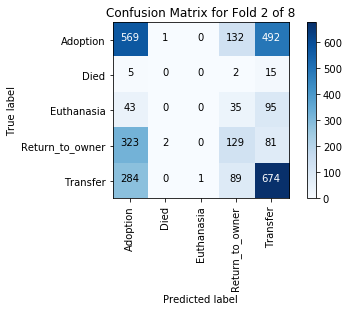

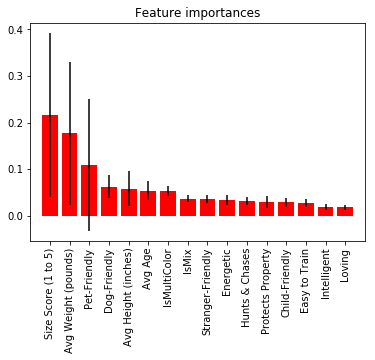


Fold 2 of 8
Train log loss: 17.8741656945
Test log loss: 18.7516143807
                 precision    recall  f1-score   support

       Adoption       0.45      0.54      0.49      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.34      0.17      0.23       535
       Transfer       0.49      0.59      0.53      1048

    avg / total       0.42      0.46      0.43      2971

Classifier score (accuracy): 0.457085156513


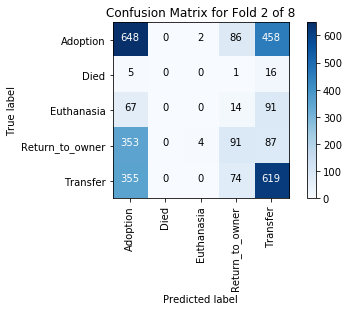

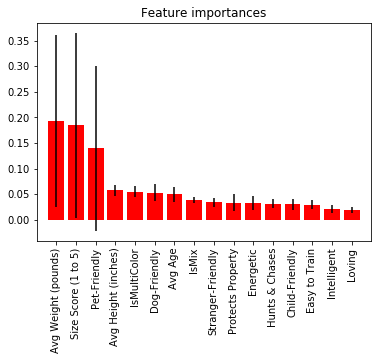


Fold 3 of 8
Train log loss: 17.8799514918
Test log loss: 18.6067482262
                 precision    recall  f1-score   support

       Adoption       0.46      0.48      0.47      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.36      0.27      0.31       535
       Transfer       0.50      0.62      0.55      1047

    avg / total       0.42      0.46      0.44      2970

Classifier score (accuracy): 0.461279461279


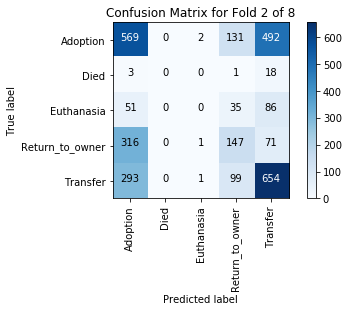

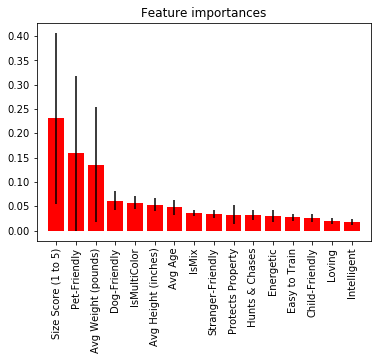


Fold 4 of 8
Train log loss: 17.7752834984
Test log loss: 19.002141626
                 precision    recall  f1-score   support

       Adoption       0.46      0.46      0.46      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.36      0.24      0.29       535
       Transfer       0.46      0.62      0.53      1047

    avg / total       0.41      0.45      0.43      2970

Classifier score (accuracy): 0.449831649832


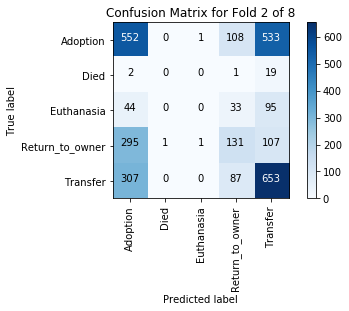

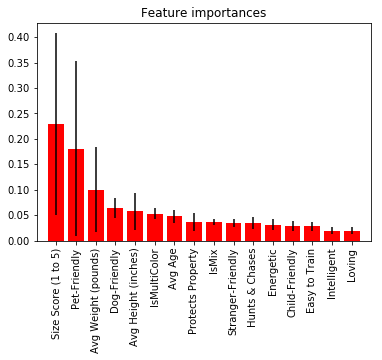


Fold 5 of 8
Train log loss: 17.7553467378
Test log loss: 19.1765798906
                 precision    recall  f1-score   support

       Adoption       0.45      0.46      0.45      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.34      0.28      0.30       535
       Transfer       0.48      0.60      0.53      1047

    avg / total       0.41      0.44      0.42      2970

Classifier score (accuracy): 0.444781144781


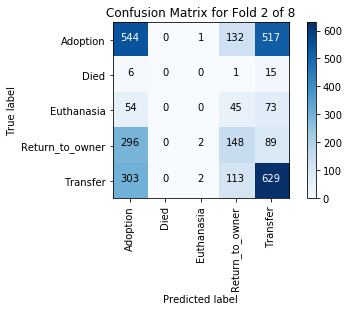

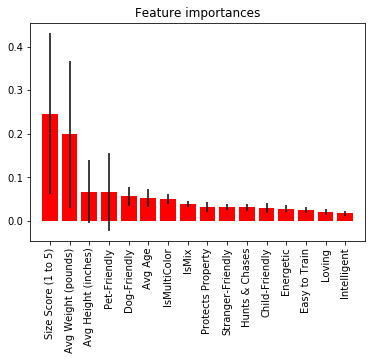


Fold 6 of 8
Train log loss: 17.8965654589
Test log loss: 18.2695009146
                 precision    recall  f1-score   support

       Adoption       0.47      0.50      0.49      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.39      0.24      0.30       535
       Transfer       0.49      0.64      0.56      1047

    avg / total       0.43      0.47      0.45      2970

Classifier score (accuracy): 0.471043771044


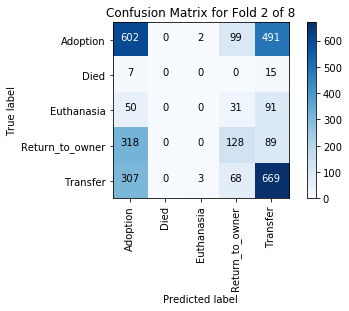

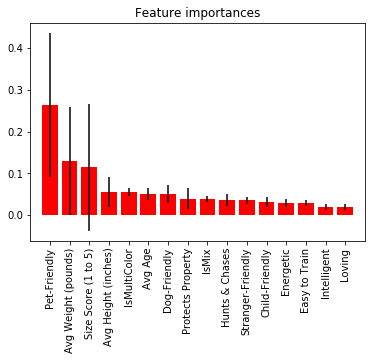


Fold 7 of 8
Train log loss: 17.7536387539
Test log loss: 19.1895021143
                 precision    recall  f1-score   support

       Adoption       0.44      0.45      0.45      1193
           Died       0.00      0.00      0.00        21
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.34      0.24      0.28       535
       Transfer       0.48      0.62      0.54      1047

    avg / total       0.41      0.44      0.42      2968

Classifier score (accuracy): 0.444407008086


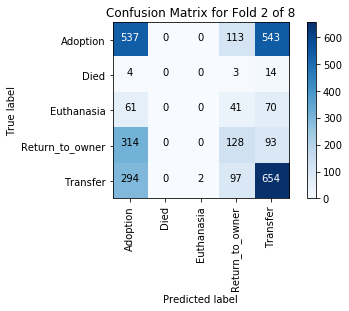

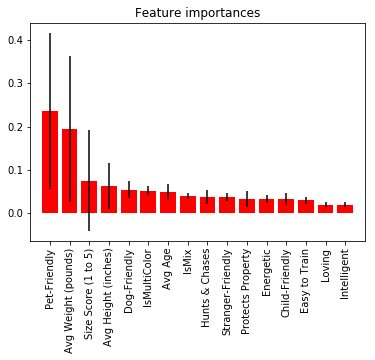


Fold 8 of 8
Train log loss: 17.8400230727
Test log loss: 18.4796418178
                 precision    recall  f1-score   support

       Adoption       0.47      0.49      0.48      1193
           Died       0.00      0.00      0.00        21
     Euthanasia       0.00      0.00      0.00       172
Return_to_owner       0.36      0.31      0.34       535
       Transfer       0.50      0.60      0.54      1047

    avg / total       0.43      0.46      0.45      2968

Classifier score (accuracy): 0.464959568733


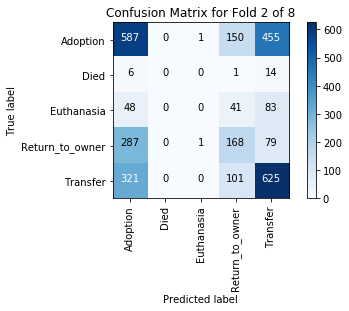

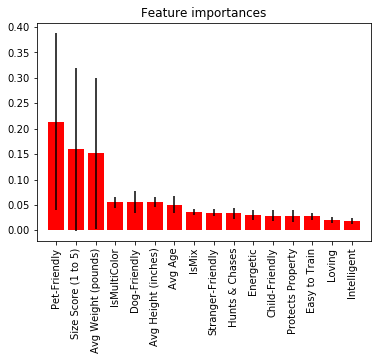

Avg. train log loss: 17.8250191972 std: 0.0538516521753
Avg. test log loss: 18.7587444789 std: 0.313619604228


In [549]:
clf = RandomForestClassifier(n_estimators=100, max_depth=15, 
                             random_state=8, max_features=None, n_jobs= -1)  
loss = TrainTest([], [])
run_classifier_CV(clf, train, test, target_names, loss, plot=True)
print('Avg. train log loss: {} std: {}'.format(mean(loss.train), std(loss.train)))
print('Avg. test log loss: {} std: {}'.format(mean(loss.test), std(loss.test)))

# TODO

* Try changing TransformedSex to not umpute Unknowns (and just just change the one NaN to an unknown). I think this will improve the results.

In [901]:
# Cross Validation
def model_cv(train, test, train_y, test_y, model, name):
    model.fit(train, train_y)
    print(name,': ',model.best_params_)
    pred_y = model.predict_proba(test)
    print('train score: {}'.format(model.score(train, train_y)))
    print('test score: {}'.format(model.score(test, test_y)))
    print('log loss: {}'.format(log_loss(test_y, pred_y)))
    print()

In [902]:
from sklearn.model_selection import GridSearchCV
def forest(train, test, train_y, test_y):
    param = [{'n_estimators':[100, 300, 500, 1000],
             'criterion': ['gini', 'entropy']
         }]
    model = GridSearchCV(RandomForestClassifier(n_jobs=-1), param, cv=3)
    name = 'Random forest'
    return model_cv(train, test, train_y, test_y, model, name)

In [903]:
forest(X.train, X.test, t.train, t.test)

('Random forest', ': ', {'n_estimators': 1000, 'criterion': 'gini'})
train score: 0.997937623637
test score: 0.666666666667


Exception: Data must be 1-dimensional